# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice. Zkusíme si ho například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint
import random

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Abychom mohli řešení vyhodnocovat, budeme také potřebovat fitness funkci, což bude hodnota rastrigin funkce v daném bodě.

In [4]:
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic a na aktualizaci akuální nejlepší pozice. Také bude potřeba funkce na update nejlepšího globálního řešení.

In [5]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*random.uniform(0, 1)*(particle.best_position - particle.position) + phi2*random.uniform(0, 1)*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat.

   0: 0.6401
   1: 0.6401
   2: 0.0158
   3: 0.0158
   4: 0.0158
   5: 0.0129
   6: 0.0053
   7: 0.0053
   8: 0.0016
   9: 0.0016
  10: 0.0001
  11: 0.0001
  12: 0.0001
  13: 0.0001
  14: 0.0001
  15: 0.0001
  16: 0.0001
  17: 0.0001
  18: 0.0001
  19: 0.0001
  20: 0.0000
  21: 0.0000
  22: 0.0000
  23: 0.0000
  24: 0.0000
  25: 0.0000
  26: 0.0000
  27: 0.0000
  28: 0.0000
  29: 0.0000
best position
[[-0.00011134  0.00018439  0.00019254]]


Text(0.5, 0, 'Generace')

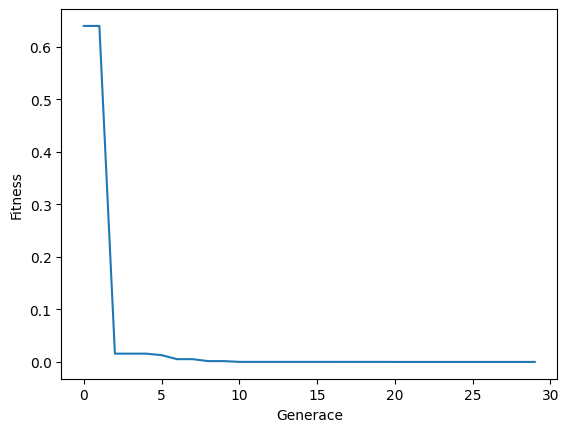

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=3000, problem_dim=3, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrcholy. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [8]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

Do této struktury si načteme vstupní data ze souboru *cities.csv*, který obsahuje hlavní evropská města s jejich souřadncemi.

In [9]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [10]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [11]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [12]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce ```compute_prob```, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [13]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution

Nyní už si můžeme vytvořit hlavní kód ACO.

In [14]:
def ant_solver(vertices, distance, ants=10, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

A zkusíme si algoritmus otestovat.

In [15]:
best_solution, pheromones = ant_solver(vertices, distance)
print('Min distance, Mean distance, Max distance')

   0, 335.8634, 391.5742, 435.3152
   1, 290.5398, 320.8908, 362.4356
   2, 270.9570, 317.8344, 366.3491
   3, 256.7805, 303.0822, 348.5120
   4, 255.9928, 297.3416, 358.4473
   5, 263.4515, 292.7659, 327.0732
   6, 245.9293, 290.9617, 338.2315
   7, 260.6610, 283.8975, 344.1535
   8, 248.2105, 282.4182, 306.0690
   9, 237.1711, 261.1424, 293.9317
  10, 240.2005, 262.9472, 304.1410
  11, 245.4418, 273.5351, 316.7209
  12, 243.6040, 281.5038, 341.6849
  13, 246.2662, 280.3363, 353.2115
  14, 246.4951, 269.0210, 305.7589
  15, 250.5389, 273.3069, 296.4336
  16, 248.8985, 276.2105, 310.3186
  17, 244.9538, 278.3379, 337.1774
  18, 248.0916, 290.7091, 326.0832
  19, 264.8081, 284.2449, 304.3122
  20, 250.6985, 286.6038, 337.3582
  21, 258.9103, 277.3968, 314.1274
  22, 247.2308, 272.3397, 326.4930
  23, 246.3200, 267.7675, 291.7513
  24, 244.1589, 267.9297, 308.5546
  25, 247.2308, 264.6022, 290.6126
  26, 247.2308, 276.3795, 320.7030
  27, 249.1132, 279.8075, 327.5659
  28, 251.6717, 284.

 238, 243.1730, 272.0957, 340.0702
 239, 233.5469, 266.1021, 300.6621
 240, 233.1696, 270.8694, 314.1044
 241, 234.9184, 273.1132, 312.1176
 242, 240.5693, 265.7113, 286.9503
 243, 241.5932, 267.2185, 306.5746
 244, 236.7253, 268.3979, 297.7089
 245, 237.6846, 273.7390, 288.6923
 246, 240.5693, 268.5890, 328.5666
 247, 241.9003, 273.2122, 306.8075
 248, 250.7789, 272.1098, 298.1595
 249, 240.5693, 285.0575, 329.8903
 250, 240.5693, 272.4509, 298.9652
 251, 235.5147, 282.2042, 337.9929
 252, 235.5147, 266.9910, 297.5872
 253, 235.5147, 266.1395, 301.3752
 254, 253.3983, 283.3451, 332.1526
 255, 256.1959, 282.3935, 341.2251
 256, 239.4696, 278.9913, 309.6177
 257, 237.0811, 271.7960, 322.1887
 258, 237.0811, 272.2531, 363.6254
 259, 245.1010, 270.6800, 320.7280
 260, 233.6752, 266.2188, 321.4609
 261, 232.7438, 265.1694, 293.0677
 262, 232.7438, 256.0647, 279.8207
 263, 233.4496, 252.6027, 277.6781
 264, 232.7438, 264.0592, 310.9575
 265, 240.1063, 265.0335, 309.9345
 266, 231.9706, 258.

 485, 260.6765, 285.3239, 305.3044
 486, 263.6968, 284.0735, 305.4118
 487, 252.1678, 278.6000, 294.5710
 488, 260.1864, 288.1959, 326.4881
 489, 253.5992, 282.1499, 306.4910
 490, 259.1279, 284.2231, 318.1480
 491, 264.4676, 282.8945, 312.2909
 492, 268.0041, 289.3795, 306.6475
 493, 249.4566, 290.8490, 342.9454
 494, 260.3701, 288.2643, 337.5394
 495, 252.3273, 274.1868, 294.1764
 496, 265.4222, 283.8999, 335.1554
 497, 258.2264, 275.8129, 316.8837
 498, 249.9895, 276.6363, 324.7640
 499, 246.6696, 278.0290, 323.1252
 500, 242.8808, 273.8338, 323.7987
 501, 247.7684, 271.2488, 324.7446
 502, 255.8546, 284.8232, 329.2123
 503, 254.3615, 277.7593, 317.3815
 504, 252.1477, 270.7920, 314.8810
 505, 255.5796, 279.6374, 327.4509
 506, 248.8642, 268.5095, 298.7239
 507, 248.0426, 290.8534, 339.0560
 508, 255.8172, 280.2529, 304.2019
 509, 245.9785, 282.1961, 358.1621
 510, 246.2573, 276.3589, 313.0860
 511, 231.2052, 263.8654, 328.1853
 512, 246.3009, 275.6009, 300.1170
 513, 244.9846, 295.

 726, 230.5441, 261.4169, 348.0794
 727, 228.6605, 268.5927, 331.5279
 728, 233.8017, 275.5584, 332.4402
 729, 231.9897, 265.5972, 320.8519
 730, 246.8626, 282.6214, 349.8560
 731, 232.2055, 268.8534, 369.0336
 732, 238.2001, 273.3599, 349.9134
 733, 237.3859, 278.3864, 322.2734
 734, 232.7960, 258.2914, 288.6832
 735, 228.9839, 272.3756, 372.8564
 736, 232.6317, 261.6586, 314.2620
 737, 232.4848, 253.0439, 287.6218
 738, 232.4848, 253.7324, 287.6218
 739, 228.6605, 258.4825, 310.3064
 740, 231.7218, 252.2553, 297.0302
 741, 230.8544, 249.7245, 294.4502
 742, 237.3568, 270.3159, 384.8512
 743, 228.6605, 249.7292, 328.7141
 744, 228.6605, 253.2796, 271.2362
 745, 230.8544, 258.4658, 290.8206
 746, 232.4848, 271.7101, 346.3460
 747, 231.2052, 271.8482, 332.3237
 748, 231.7218, 261.3548, 304.8523
 749, 231.7218, 258.3496, 282.6705
 750, 232.2055, 259.4437, 316.4923
 751, 228.6605, 261.2991, 312.2255
 752, 232.0447, 255.4741, 313.7312
 753, 235.6639, 272.8077, 320.7516
 754, 232.0447, 265.

 965, 236.1847, 271.4532, 351.2807
 966, 232.2512, 258.8243, 316.7031
 967, 232.2177, 257.6645, 308.7022
 968, 232.2512, 250.9116, 287.8759
 969, 235.1003, 266.2262, 304.0232
 970, 233.3569, 251.2123, 279.1414
 971, 232.8238, 267.5016, 311.3253
 972, 232.8238, 265.7198, 304.8340
 973, 232.2512, 254.9689, 283.2431
 974, 237.5161, 274.9252, 312.8109
 975, 231.0843, 270.1175, 305.6161
 976, 258.1182, 282.3857, 309.6745
 977, 233.0014, 268.9981, 325.2017
 978, 243.4973, 278.5066, 317.6935
 979, 254.5144, 282.7110, 303.0355
 980, 244.2080, 272.4194, 328.3977
 981, 244.5981, 278.0062, 316.9325
 982, 232.8238, 269.9733, 304.8390
 983, 236.8270, 273.7628, 317.5947
 984, 236.2593, 261.9704, 280.7350
 985, 234.3544, 265.0559, 294.6657
 986, 232.2512, 267.0349, 313.9350
 987, 243.6727, 266.6223, 316.2626
 988, 232.2512, 257.2475, 309.5422
 989, 232.2512, 265.2869, 301.7108
 990, 232.2512, 261.1041, 301.6587
 991, 233.8755, 254.2097, 291.3667
 992, 239.9654, 266.3039, 300.7077
 993, 233.8755, 272.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  228.66045709317382
[Vertex(name='Skopje', x=21.46666667, y=42.0),
 Vertex(name='Pristina', x=21.16666667, y=42.65),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Bucharest', x=26.1, y=44.43333333),
 Vertex(name='Chisinau', x=28.81666667, y=47.01666667),
 Vertex(name='Kyiv', x=30.51666667, y=50.41666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Vilnius', x=25.26666667, y=54.7),
 Vertex(name='Riga', x=24.11666667, y=56.96666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Stockholm', x=18.06666667, y=59.31666667),
 Vertex(name='Warsaw', x=21.01666667, y=52.25),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Bern'

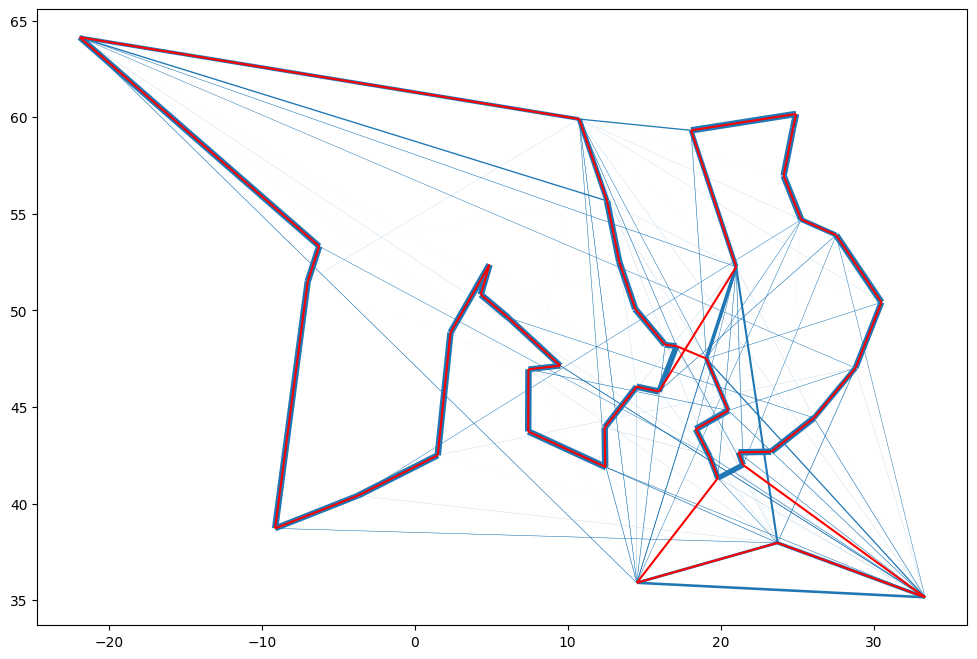

In [16]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Pěkná simulace hledání nejkratší cesty v grafu se nachází [zde](http://thiagodnf.github.io/aco-simulator).

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy. Při nalezení nového zdroje se z nich zase stávají dělnice.

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic. Pro inspiraci je vyřešený například [zde](https://github.com/rwuilbercq/Hive).

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline. Pro sepsání popisu algoritmu a výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/11_rojove%20algoritmy/DU3_spojita_optimalizace.pdf).